# Asset Pricing and Portfolio Management | Heuristic portfolios


## Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Load stock price data and compute returns

In [3]:
tickers = ["GOOG", "GLW", "MSFT", "AMZN", "META", "AMZN", "UNH", "BE", "ATRO", "META"]

to_date = datetime.now()  # today
from_date = to_date - timedelta(days=5*365)  # past five years


start_date = from_date.strftime('%Y-%m-%d')
end_date = to_date.strftime('%Y-%m-%d')
interval = '1d'  # daily frequency

In [9]:
# Download adjusted close prices
prices_data = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date,
        interval=interval,
        group_by='ticker',
        auto_adjust=False,
        threads=True,
        progress=False
    )

# Handle duplicate tickers by using only unique tickers
unique_tickers = list(dict.fromkeys(tickers))  # Preserves order
# Keep only the 'Adj Close' column for each ticker
prices = prices_data.xs('Adj Close', axis=1, level=1)[unique_tickers].dropna()

# Basic info about the data
print(f"Data shape: {prices.shape}")
print(f"\nFirst 3 rows:")
print(prices.head(3))
print(f"\nLast 3 rows:")
print(prices.tail(3))

Data shape: (1254, 8)

First 3 rows:
Ticker           GOOG        GLW        MSFT        AMZN        META  \
Date                                                                   
2020-09-25  71.756950  27.118738  199.263077  154.756500  253.258728   
2020-09-28  72.728294  27.840164  200.816406  158.702499  255.246475   
2020-09-29  72.967171  27.788012  198.726151  157.244003  260.186035   

Ticker             UNH         BE  ATRO  
Date                                     
2020-09-25  279.694031  15.170000  7.87  
2020-09-28  280.368958  16.879999  7.99  
2020-09-29  281.219635  16.879999  7.70  

Last 3 rows:
Ticker            GOOG        GLW        MSFT        AMZN        META  \
Date                                                                    
2025-09-19  255.240005  79.559998  517.929993  231.479996  777.854980   
2025-09-22  252.880005  79.160004  514.450012  227.630005  765.159973   
2025-09-23  252.339996  81.000000  509.230011  220.710007  755.400024   

Ticker      

In [10]:
# Compute log-returns and linear returns
X_log = np.log(prices / prices.shift(1)).dropna()
X_lin = (prices / prices.shift(1) - 1).dropna()

N = X_log.shape[1]  # number of stocks
T = X_log.shape[0]  # number of days

print(f"Number of stocks (N): {N}")
print(f"Number of trading days (T): {T}")
print(f"\nUnique tickers: {unique_tickers}")

Number of stocks (N): 8
Number of trading days (T): 1253

Unique tickers: ['GOOG', 'GLW', 'MSFT', 'AMZN', 'META', 'UNH', 'BE', 'ATRO']


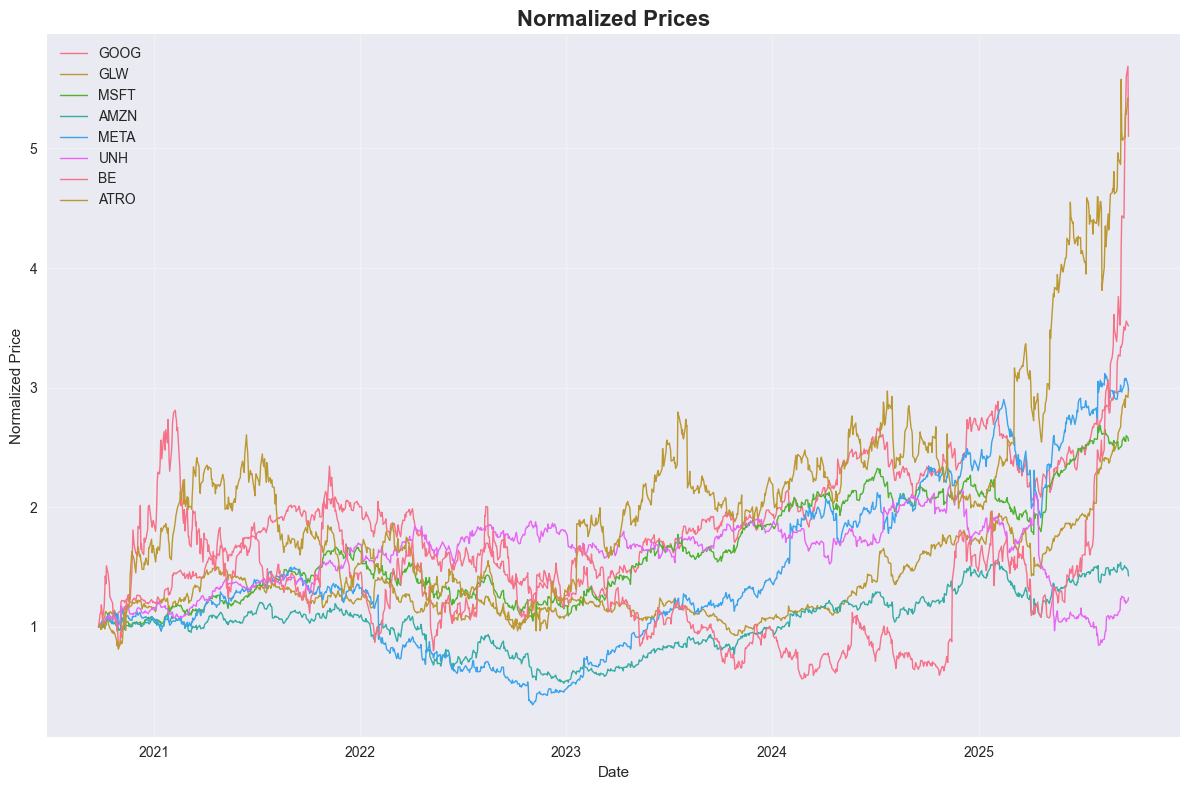

In [12]:
# Plot normalized prices
normalized_prices = prices / prices.iloc[0]

plt.figure(figsize=(12, 8))
for ticker in unique_tickers:
    plt.plot(normalized_prices.index, normalized_prices[ticker], label=ticker, linewidth=1)

plt.title('Normalized Prices', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Data Splitting and Parameter Estimation

In [13]:
# Divide the data into a training set (trn) and test set (tst)
T_trn = int(0.70 * T)  # 70% of data for training set

X_log_trn = X_log.iloc[:T_trn]
X_log_tst = X_log.iloc[T_trn:]
X_lin_trn = X_lin.iloc[:T_trn]
X_lin_tst = X_lin.iloc[T_trn:]

print(f"Training set size: {T_trn} days")
print(f"Test set size: {T - T_trn} days")
print(f"Training period: {X_log_trn.index[0].strftime('%Y-%m-%d')} to {X_log_trn.index[-1].strftime('%Y-%m-%d')}")
print(f"Test period: {X_log_tst.index[0].strftime('%Y-%m-%d')} to {X_log_tst.index[-1].strftime('%Y-%m-%d')}")

Training set size: 877 days
Test set size: 376 days
Training period: 2020-09-28 to 2024-03-22
Test period: 2024-03-25 to 2025-09-23


In [14]:
# Estimate expected return and covariance matrix from log returns
mu_log = X_log_trn.mean()
Sigma_log = X_log_trn.cov()

# Display annualized returns (assuming 252 trading days per year)
annual_returns = mu_log * 252
annual_volatility = np.sqrt(np.diag(Sigma_log)) * np.sqrt(252)
annual_sharpe = annual_returns / annual_volatility

annualized_stats = pd.DataFrame({
    'Annualized Return': annual_returns,
    'Annualized Std Dev': annual_volatility,
    'Annualized Sharpe': annual_sharpe
})

print("Annualized Statistics (Training Data):")
print(annualized_stats.round(4))

Annualized Statistics (Training Data):
        Annualized Return  Annualized Std Dev  Annualized Sharpe
Ticker                                                          
GOOG               0.2133              0.3119             0.6838
GLW                0.0424              0.2672             0.1586
MSFT               0.2170              0.2721             0.7976
AMZN               0.0416              0.3650             0.1140
META               0.1994              0.4727             0.4219
UNH                0.1528              0.2220             0.6882
BE                -0.1235              0.7675            -0.1609
ATRO               0.2442              0.5796             0.4213


## Buy & Hold (B&H) Strategy

In [15]:
# Estimate mu and sigma from the in-sample log-returns
mu = X_log_trn.mean()  # mean return
Sigma = X_log_trn.cov()  # var-cov matrix

print("Daily Mean Returns:")
print(mu.round(6))
print(f"\nDaily Volatilities:")
print(np.sqrt(np.diag(Sigma)).round(6))

Daily Mean Returns:
Ticker
GOOG    0.000846
GLW     0.000168
MSFT    0.000861
AMZN    0.000165
META    0.000791
UNH     0.000606
BE     -0.000490
ATRO    0.000969
dtype: float64

Daily Volatilities:
[0.019649 0.016829 0.017138 0.022994 0.02978  0.013983 0.048347 0.036512]


In [16]:
# Buy & Hold simply means to allocate the whole budget to one stock and stick to it
# Create N different B&H portfolios (identity matrix)
w_BnH = pd.DataFrame(np.eye(N), 
                     index=unique_tickers, 
                     columns=unique_tickers)

print("Buy & Hold Portfolio Weights:")
print(w_BnH)

Buy & Hold Portfolio Weights:
      GOOG  GLW  MSFT  AMZN  META  UNH   BE  ATRO
GOOG   1.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0
GLW    0.0  1.0   0.0   0.0   0.0  0.0  0.0   0.0
MSFT   0.0  0.0   1.0   0.0   0.0  0.0  0.0   0.0
AMZN   0.0  0.0   0.0   1.0   0.0  0.0  0.0   0.0
META   0.0  0.0   0.0   0.0   1.0  0.0  0.0   0.0
UNH    0.0  0.0   0.0   0.0   0.0  1.0  0.0   0.0
BE     0.0  0.0   0.0   0.0   0.0  0.0  1.0   0.0
ATRO   0.0  0.0   0.0   0.0   0.0  0.0  0.0   1.0


In [17]:
# Compute returns of all B&H portfolios
ret_BnH = X_lin @ w_BnH
ret_BnH_trn = ret_BnH.iloc[:T_trn]
ret_BnH_tst = ret_BnH.iloc[T_trn:]

print("First 5 rows of B&H returns:")
print(ret_BnH.head())

First 5 rows of B&H returns:
                GOOG       GLW      MSFT      AMZN      META       UNH  \
Date                                                                     
2020-09-28  0.013537  0.026602  0.007795  0.025498  0.007849  0.002413   
2020-09-29  0.003285 -0.001873 -0.010409 -0.009190  0.019352  0.003034   
2020-09-30  0.000184  0.013763  0.014812  0.001224  0.000420  0.025053   
2020-10-01  0.013942  0.003703  0.010127  0.023035  0.018060  0.004170   
2020-10-02 -0.021254  0.008608 -0.029511 -0.029883 -0.025091 -0.003482   

                  BE      ATRO  
Date                            
2020-09-28  0.112722  0.015248  
2020-09-29  0.000000 -0.036295  
2020-09-30  0.064573  0.002597  
2020-10-01 -0.038397  0.024611  
2020-10-02 -0.075810  0.017699  


### Performance Analysis for B&H Strategy

In [18]:
def calculate_performance_metrics(returns, rf=0.0, trading_days=252):
    """
    Calculate performance metrics similar to R's table.AnnualizedReturns
    """
    annual_return = returns.mean() * trading_days
    annual_std = returns.std() * np.sqrt(trading_days)
    annual_sharpe = (annual_return - rf) / annual_std
    
    return pd.DataFrame({
        'Annualized Return': annual_return,
        'Annualized Std Dev': annual_std,
        'Annualized Sharpe': annual_sharpe
    })

# Performance metrics for training set
print("B&H Performance (Training Set):")
bnh_performance_trn = calculate_performance_metrics(ret_BnH_trn)
print(bnh_performance_trn.round(4))

print("\nB&H Performance (Test Set):")
bnh_performance_tst = calculate_performance_metrics(ret_BnH_tst)
print(bnh_performance_tst.round(4))

B&H Performance (Training Set):
      Annualized Return  Annualized Std Dev  Annualized Sharpe
GOOG             0.2619              0.3117             0.8405
GLW              0.0781              0.2678             0.2915
MSFT             0.2541              0.2723             0.9331
AMZN             0.1081              0.3650             0.2962
META             0.3099              0.4667             0.6641
UNH              0.1775              0.2228             0.7966
BE               0.1724              0.7760             0.2221
ATRO             0.4149              0.5960             0.6962

B&H Performance (Test Set):
      Annualized Return  Annualized Std Dev  Annualized Sharpe
GOOG             0.3911              0.3031             1.2902
GLW              0.6856              0.3191             2.1486
MSFT             0.1494              0.2318             0.6445
AMZN             0.1917              0.3192             0.6006
META             0.3299              0.3554             0

In [19]:
# Calculate wealth evolution
# A. Arithmetic (same quantity repeatedly invested)
wealth_arith_BnH_trn = (1 + ret_BnH_trn).cumprod()

# B. Geometric (compounding/reinvesting)
wealth_geom_BnH_trn = (1 + ret_BnH_trn).cumprod()

print("First 3 rows of cumulative wealth (geometric):")
print(wealth_geom_BnH_trn.head(3))

First 3 rows of cumulative wealth (geometric):
                GOOG       GLW      MSFT      AMZN      META       UNH  \
Date                                                                     
2020-09-28  1.013537  1.026602  1.007795  1.025498  1.007849  1.002413   
2020-09-29  1.016866  1.024679  0.997305  1.016074  1.027353  1.005455   
2020-09-30  1.017052  1.038782  1.012078  1.017317  1.027784  1.030645   

                  BE      ATRO  
Date                            
2020-09-28  1.112722  1.015248  
2020-09-29  1.112722  0.978399  
2020-09-30  1.184575  0.980940  


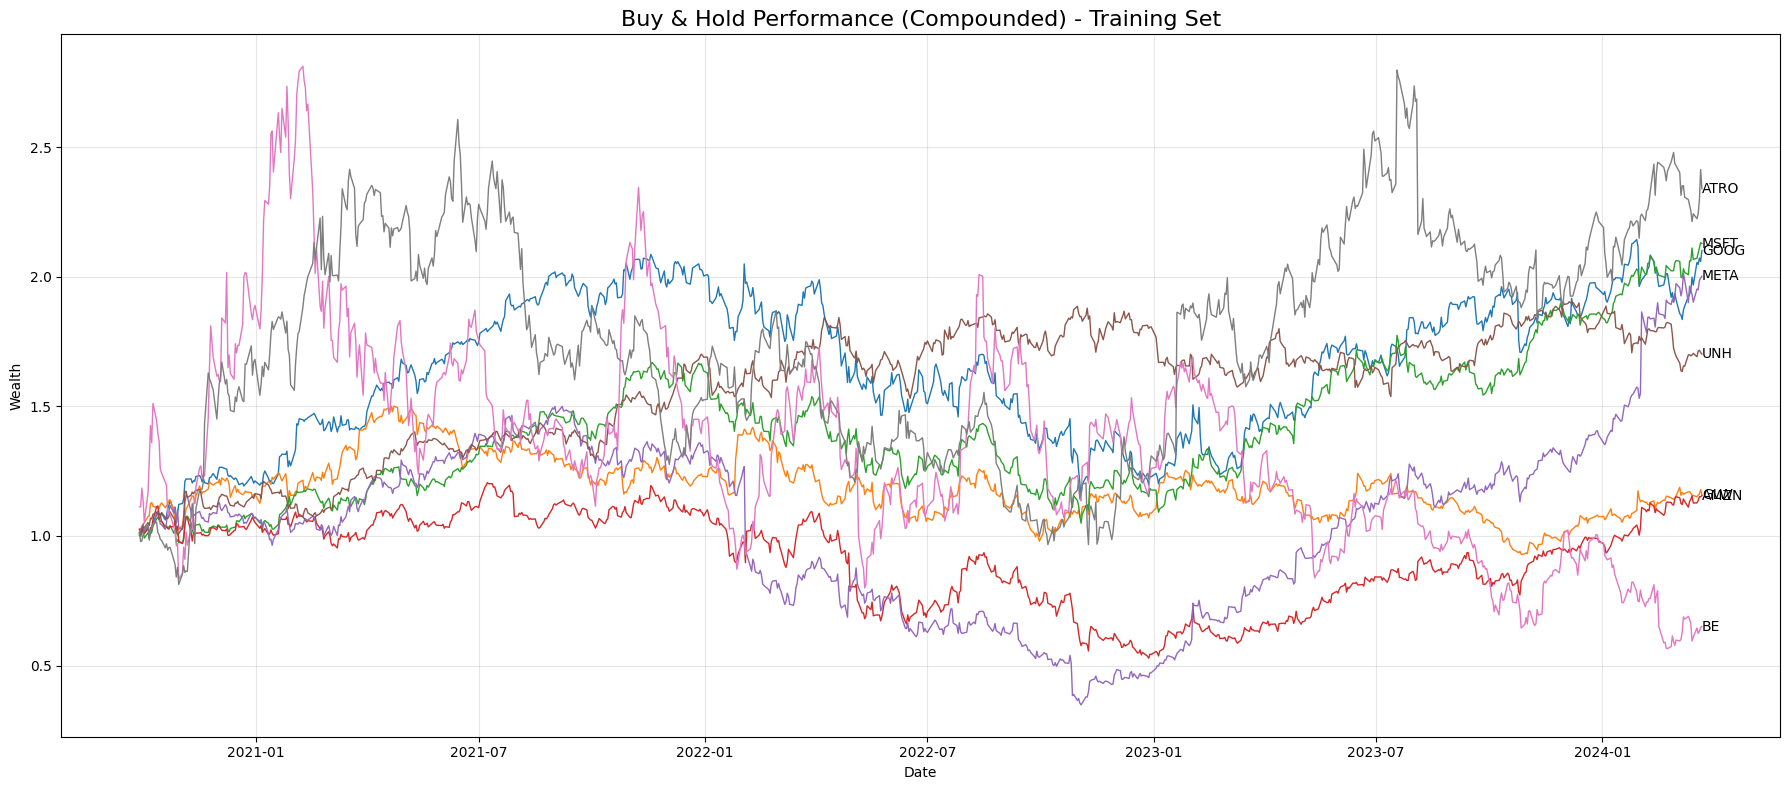

In [28]:

plt.style.use('default')  # Set background to white

fig, ax = plt.subplots(figsize=(18, 8))
lines = []
for ticker in wealth_geom_BnH_trn.columns:
    line, = ax.plot(wealth_geom_BnH_trn.index, wealth_geom_BnH_trn[ticker], label=ticker, linewidth=1)
    lines.append(line)
    ax.text(
        wealth_geom_BnH_trn.index[-1],
        wealth_geom_BnH_trn[ticker].iloc[-1],
        ticker,
        fontsize=10,
        va='center',
        ha='left'
    )

plt.title('Buy & Hold Performance (Compounded) - Training Set', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.grid(True, alpha=0.3)
plt.tight_layout()


plt.show()


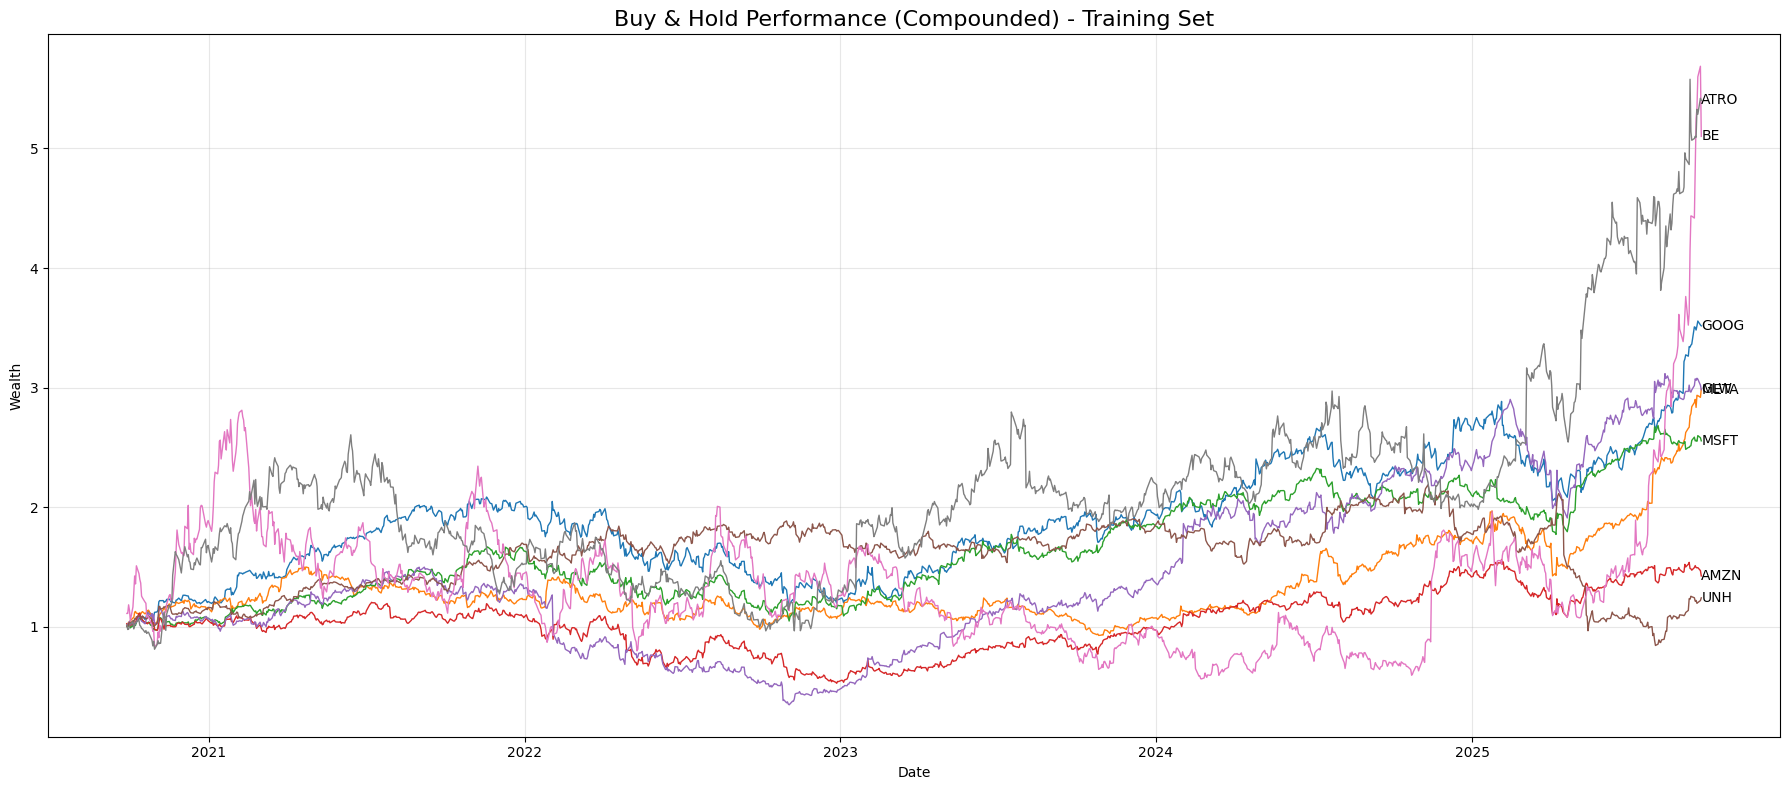

In [30]:
# Plot all B&H strategies
wealth_geom_BnH = (1 + ret_BnH).cumprod()

fig, ax = plt.subplots(figsize=(18, 8))
lines = []
for ticker in wealth_geom_BnH.columns:
    line, = ax.plot(wealth_geom_BnH.index, wealth_geom_BnH[ticker], label=ticker, linewidth=1)
    lines.append(line)
    ax.text(
        wealth_geom_BnH.index[-1],
        wealth_geom_BnH[ticker].iloc[-1],
        ticker,
        fontsize=10,
        va='center',
        ha='left'
    )

plt.title('Buy & Hold Performance (Compounded) - Training Set', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.grid(True, alpha=0.3)
plt.tight_layout()



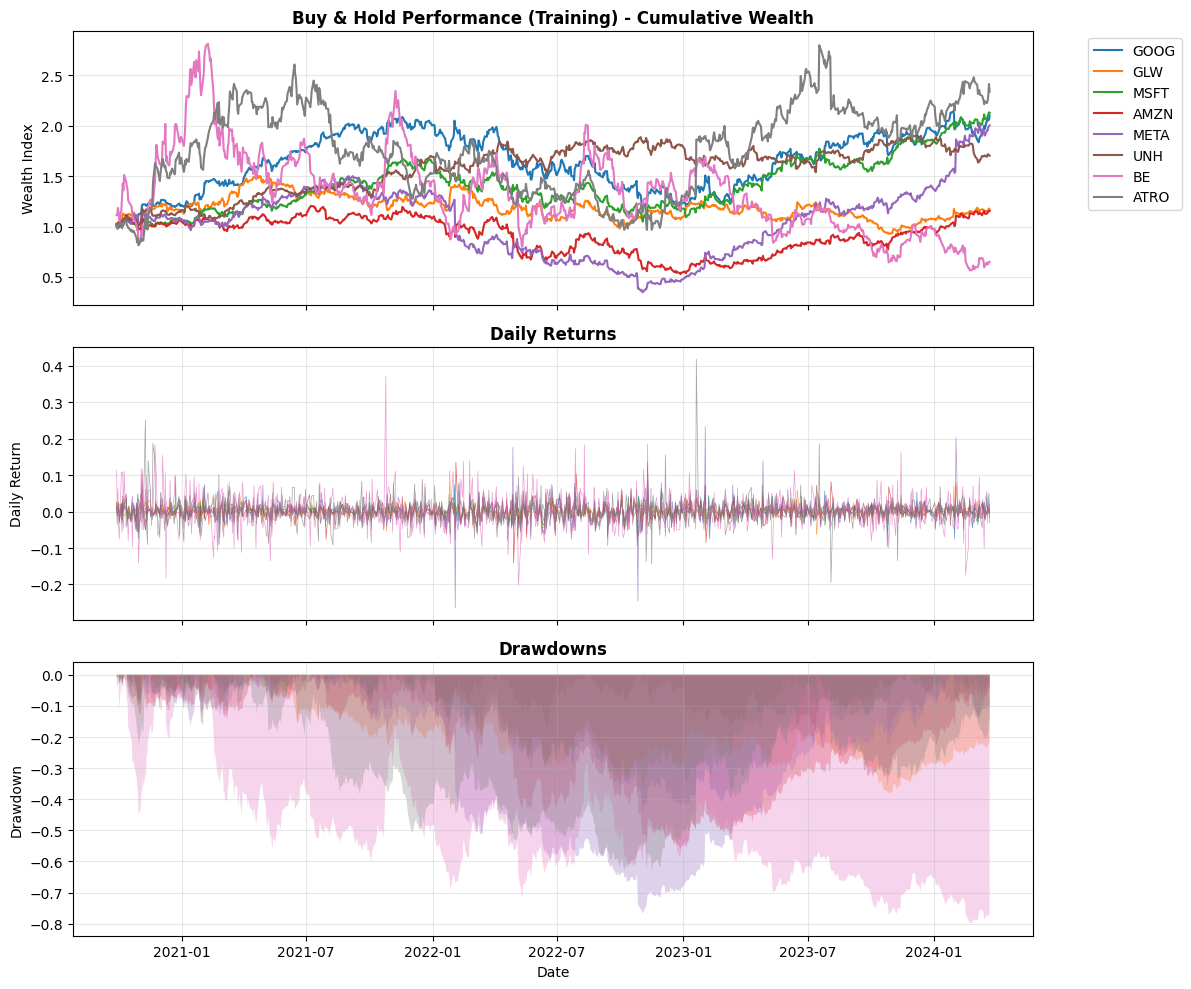

In [31]:
# Combined performance summary plot
def plot_performance_summary(returns, title="Performance Summary"):
    """
    Create a performance summary plot similar to R's charts.PerformanceSummary
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # 1. Cumulative returns
    wealth = (1 + returns).cumprod()
    for col in wealth.columns:
        axes[0].plot(wealth.index, wealth[col], label=col, linewidth=1.5)
    axes[0].set_title(f'{title} - Cumulative Wealth', fontweight='bold')
    axes[0].set_ylabel('Wealth Index')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Daily returns
    for col in returns.columns:
        axes[1].plot(returns.index, returns[col], alpha=0.7, linewidth=0.5)
    axes[1].set_title('Daily Returns', fontweight='bold')
    axes[1].set_ylabel('Daily Return')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Drawdowns
    for col in wealth.columns:
        running_max = wealth[col].expanding().max()
        drawdown = (wealth[col] / running_max - 1)
        axes[2].fill_between(drawdown.index, drawdown, 0, alpha=0.3)
    axes[2].set_title('Drawdowns', fontweight='bold')
    axes[2].set_ylabel('Drawdown')
    axes[2].set_xlabel('Date')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot performance summary for training data
plot_performance_summary(ret_BnH_trn, "Buy & Hold Performance (Training)")

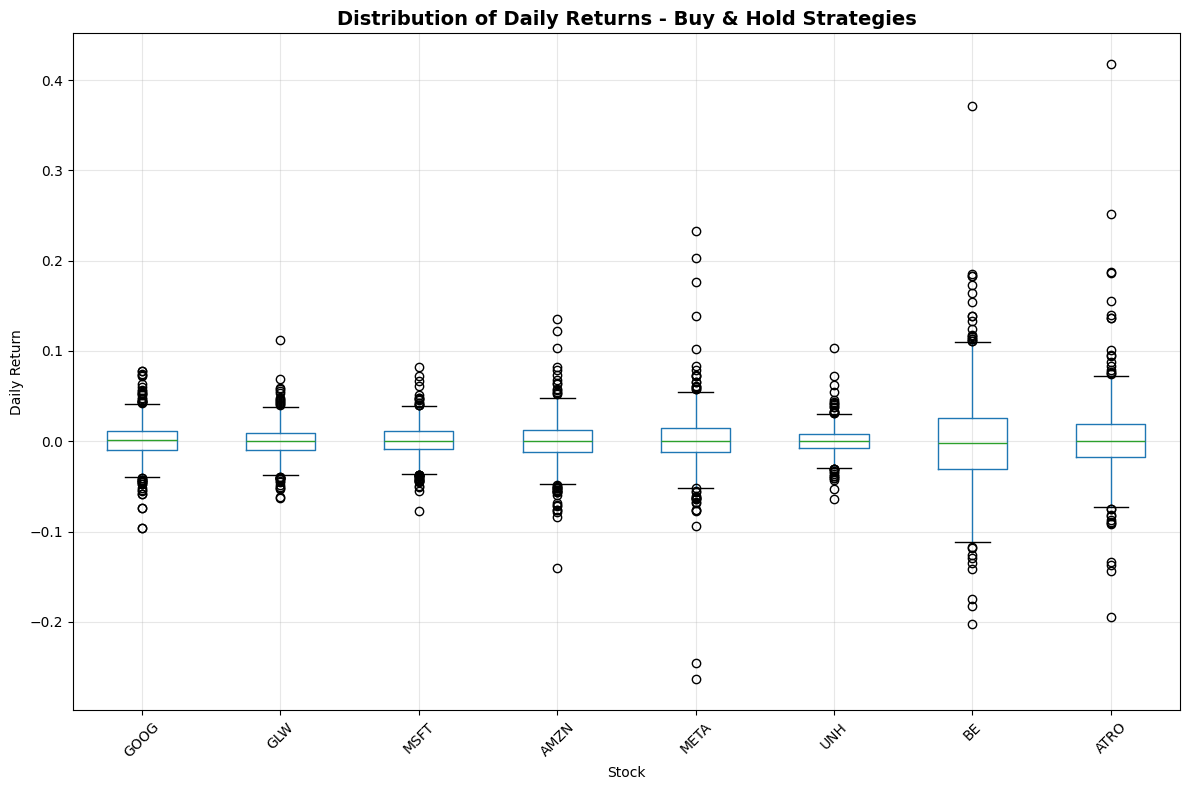

In [32]:
# Box plot of returns
plt.figure(figsize=(12, 8))
ret_BnH_trn.boxplot(ax=plt.gca())
plt.title('Distribution of Daily Returns - Buy & Hold Strategies', fontsize=14, fontweight='bold')
plt.ylabel('Daily Return')
plt.xlabel('Stock')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

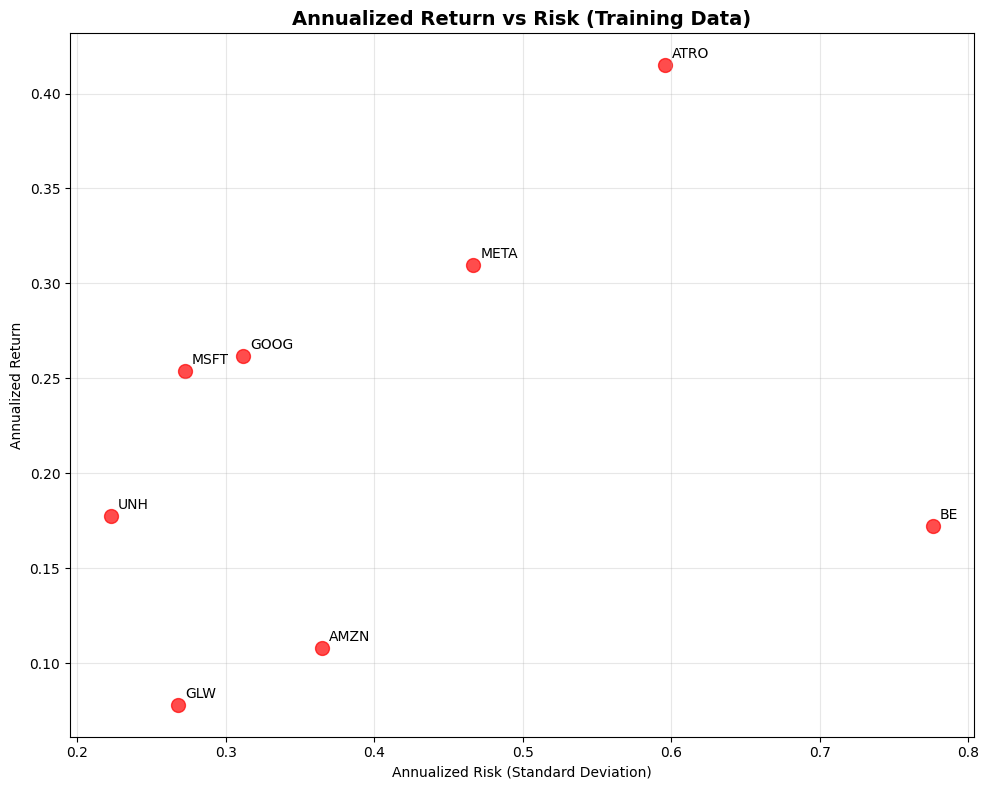

In [33]:
# Risk-Return scatter plot
annual_ret = ret_BnH_trn.mean() * 252
annual_vol = ret_BnH_trn.std() * np.sqrt(252)

plt.figure(figsize=(10, 8))
plt.scatter(annual_vol, annual_ret, s=100, c='red', alpha=0.7)

# Add labels for each point
for i, ticker in enumerate(unique_tickers):
    plt.annotate(ticker, (annual_vol.iloc[i], annual_ret.iloc[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.title('Annualized Return vs Risk (Training Data)', fontsize=14, fontweight='bold')
plt.xlabel('Annualized Risk (Standard Deviation)')
plt.ylabel('Annualized Return')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Heuristic Portfolios: EWP, Quintile Portfolios, and GMRP

In [34]:
# Equal-weighted portfolio (EWP)
w_EWP = pd.Series(1/N, index=unique_tickers, name='EWP')

print("Equal-Weighted Portfolio:")
print(w_EWP)
print(f"\nSum of weights: {w_EWP.sum():.6f}")

Equal-Weighted Portfolio:
GOOG    0.125
GLW     0.125
MSFT    0.125
AMZN    0.125
META    0.125
UNH     0.125
BE      0.125
ATRO    0.125
Name: EWP, dtype: float64

Sum of weights: 1.000000


In [35]:
# Find indices of sorted stocks for quintile portfolios
i1 = mu.sort_values(ascending=False).index  # sorted by return
i2 = (mu/np.diag(Sigma)).sort_values(ascending=False).index  # sorted by return/variance
i3 = (mu/np.sqrt(np.diag(Sigma))).sort_values(ascending=False).index  # sorted by return/std dev (Sharpe)

print("Stock rankings:")
ranking_df = pd.DataFrame({
    'By Return': [list(unique_tickers).index(stock) for stock in i1],
    'By Return/Var': [list(unique_tickers).index(stock) for stock in i2],
    'By Sharpe': [list(unique_tickers).index(stock) for stock in i3]
}, index=i1)
print(ranking_df)

print(f"\nTicker order: {unique_tickers}")

Stock rankings:
        By Return  By Return/Var  By Sharpe
Ticker                                     
ATRO            7              5          2
MSFT            2              2          5
GOOG            0              0          0
META            4              4          4
UNH             5              7          7
GLW             1              1          1
AMZN            3              3          3
BE              6              6          6

Ticker order: ['GOOG', 'GLW', 'MSFT', 'AMZN', 'META', 'UNH', 'BE', 'ATRO']


In [36]:
# Create quintile portfolios
# Steps: 1) rank the N stocks
#        2) divide them into five parts
#        3) long the top part

n_top = max(1, round(N/5))  # number of stocks in top quintile

# Initialize portfolios
w_QuintP_1 = pd.Series(0.0, index=unique_tickers)
w_QuintP_2 = pd.Series(0.0, index=unique_tickers)
w_QuintP_3 = pd.Series(0.0, index=unique_tickers)

# Assign equal weights to top quintile
w_QuintP_1[i1[:n_top]] = 1/n_top
w_QuintP_2[i2[:n_top]] = 1/n_top
w_QuintP_3[i3[:n_top]] = 1/n_top

# Combine quintile portfolios
w_QuintP = pd.DataFrame({
    'QuintP (mu)': w_QuintP_1,
    'QuintP (mu/sigma2)': w_QuintP_2,
    'QuintP (mu/sigma)': w_QuintP_3
})

print(f"Top {n_top} stocks selected for quintile portfolios:")
print(w_QuintP.round(4))

Top 2 stocks selected for quintile portfolios:
      QuintP (mu)  QuintP (mu/sigma2)  QuintP (mu/sigma)
GOOG          0.0                 0.0                0.0
GLW           0.0                 0.0                0.0
MSFT          0.5                 0.5                0.5
AMZN          0.0                 0.0                0.0
META          0.0                 0.0                0.0
UNH           0.0                 0.5                0.5
BE            0.0                 0.0                0.0
ATRO          0.5                 0.0                0.0


In [37]:
# Global Maximum Return Portfolio (GMRP)
# GMRP chooses the stock with the highest return during the in-sample period
i_max = mu.idxmax()
w_GMRP = pd.Series(0.0, index=unique_tickers)
w_GMRP[i_max] = 1.0
w_GMRP.name = 'GMRP'

print(f"Stock with highest return: {i_max} (return = {mu[i_max]:.6f})")
print("\nGMRP Portfolio:")
print(w_GMRP)

Stock with highest return: ATRO (return = 0.000969)

GMRP Portfolio:
GOOG    0.0
GLW     0.0
MSFT    0.0
AMZN    0.0
META    0.0
UNH     0.0
BE      0.0
ATRO    1.0
Name: GMRP, dtype: float64


In [38]:
# Combine all heuristic portfolios
w_heuristic = pd.concat([w_EWP, w_QuintP, w_GMRP], axis=1)

# Remove QuintP (mu/sigma2) if it's identical to QuintP (mu/sigma)
if w_heuristic['QuintP (mu/sigma2)'].equals(w_heuristic['QuintP (mu/sigma)']):
    w_heuristic = w_heuristic.drop('QuintP (mu/sigma2)', axis=1)
    print("Note: Removed QuintP (mu/sigma2) as it's identical to QuintP (mu/sigma)")

print("\nHeuristic Portfolio Weights:")
print(w_heuristic.round(2))

Note: Removed QuintP (mu/sigma2) as it's identical to QuintP (mu/sigma)

Heuristic Portfolio Weights:
       EWP  QuintP (mu)  QuintP (mu/sigma)  GMRP
GOOG  0.12          0.0                0.0   0.0
GLW   0.12          0.0                0.0   0.0
MSFT  0.12          0.5                0.5   0.0
AMZN  0.12          0.0                0.0   0.0
META  0.12          0.0                0.0   0.0
UNH   0.12          0.0                0.5   0.0
BE    0.12          0.0                0.0   0.0
ATRO  0.12          0.5                0.0   1.0


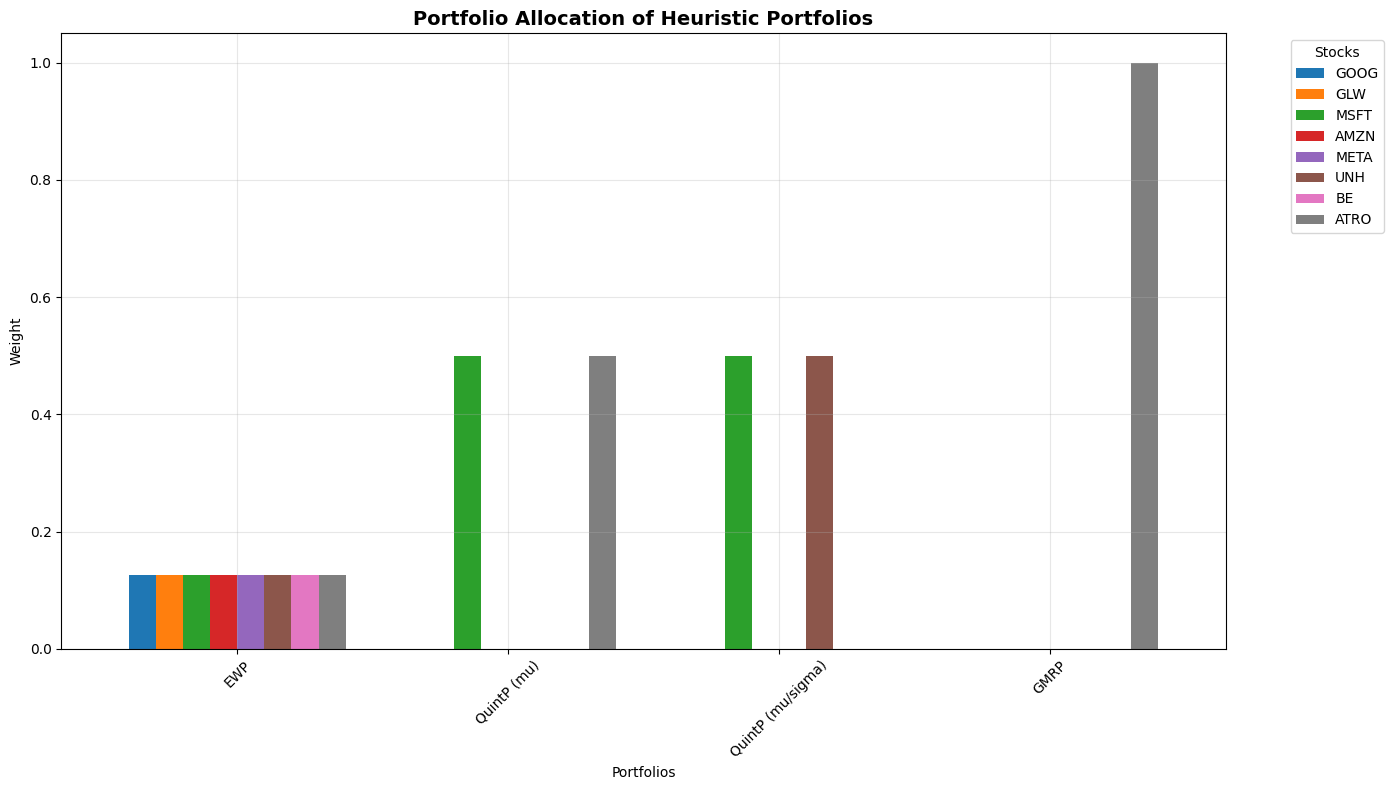

In [39]:
# Bar plot of portfolio allocations
fig, ax = plt.subplots(figsize=(14, 8))
w_heuristic.T.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Portfolio Allocation of Heuristic Portfolios', fontsize=14, fontweight='bold')
ax.set_xlabel('Portfolios')
ax.set_ylabel('Weight')
ax.legend(title='Stocks', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Performance Comparison of Heuristic Portfolios

In [40]:
# Compute returns of all heuristic portfolios
ret_heuristic = X_lin @ w_heuristic
ret_heuristic_trn = ret_heuristic.iloc[:T_trn]        # training set
ret_heuristic_tst = ret_heuristic.iloc[T_trn:]        # test set

print("First 5 rows of heuristic portfolio returns:")
print(ret_heuristic.head())

First 5 rows of heuristic portfolio returns:
                 EWP  QuintP (mu)  QuintP (mu/sigma)      GMRP
Date                                                          
2020-09-28  0.026458     0.011522           0.005104  0.015248
2020-09-29 -0.004012    -0.023352          -0.003687 -0.036295
2020-09-30  0.015328     0.008705           0.019933  0.002597
2020-10-01  0.007406     0.017369           0.007148  0.024611
2020-10-02 -0.019841    -0.005906          -0.016497  0.017699


In [41]:
# Performance metrics for training and test sets
print("Heuristic Portfolios Performance (Training Set):")
heuristic_performance_trn = calculate_performance_metrics(ret_heuristic_trn)
print(heuristic_performance_trn.round(4))

print("\nHeuristic Portfolios Performance (Test Set):")
heuristic_performance_tst = calculate_performance_metrics(ret_heuristic_tst)
print(heuristic_performance_tst.round(4))

Heuristic Portfolios Performance (Training Set):
                   Annualized Return  Annualized Std Dev  Annualized Sharpe
EWP                           0.2221              0.2640             0.8414
QuintP (mu)                   0.3345              0.3493             0.9577
QuintP (mu/sigma)             0.2158              0.2008             1.0745
GMRP                          0.4149              0.5960             0.6962

Heuristic Portfolios Performance (Test Set):
                   Annualized Return  Annualized Std Dev  Annualized Sharpe
EWP                           0.5149              0.2511             2.0505
QuintP (mu)                   0.4272              0.3241             1.3181
QuintP (mu/sigma)             0.0169              0.2412             0.0701
GMRP                          0.7050              0.5428             1.2987


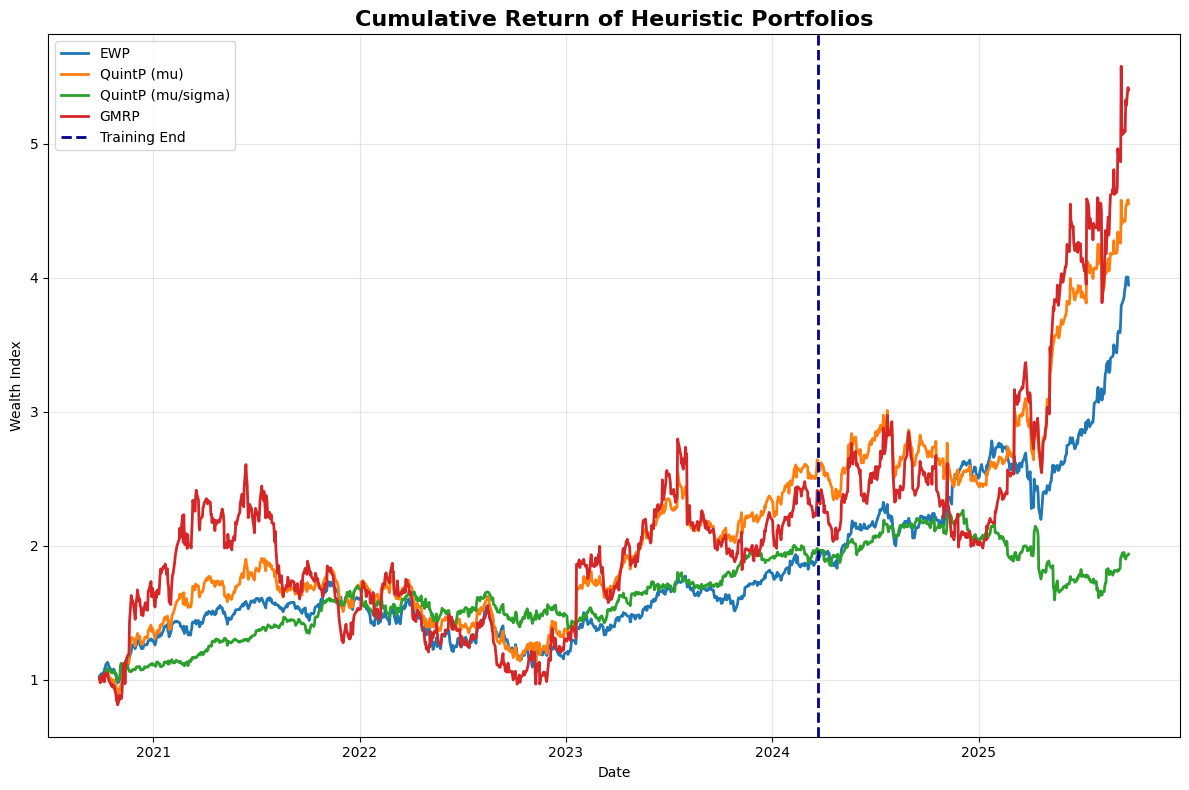

In [42]:
# Plot cumulative returns of heuristic portfolios
wealth_heuristic = (1 + ret_heuristic).cumprod()

plt.figure(figsize=(12, 8))
for col in wealth_heuristic.columns:
    plt.plot(wealth_heuristic.index, wealth_heuristic[col], label=col, linewidth=2)

# Add vertical line at training/test split
plt.axvline(x=X_lin.index[T_trn-1], color='darkblue', linestyle='--', linewidth=2, label='Training End')

plt.title('Cumulative Return of Heuristic Portfolios', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Wealth Index')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

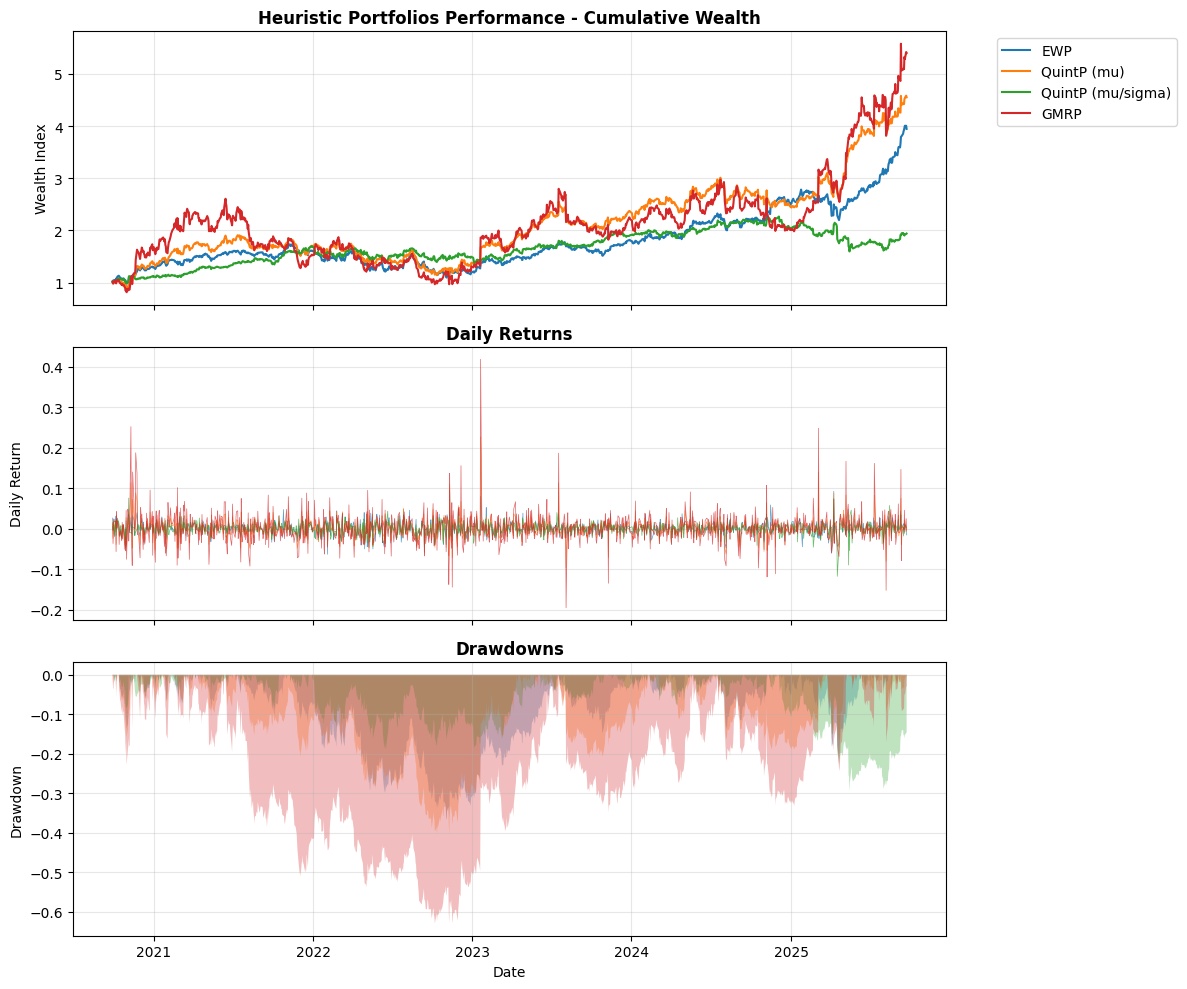

In [43]:
# Performance summary plot for heuristic portfolios
plot_performance_summary(ret_heuristic, "Heuristic Portfolios Performance")

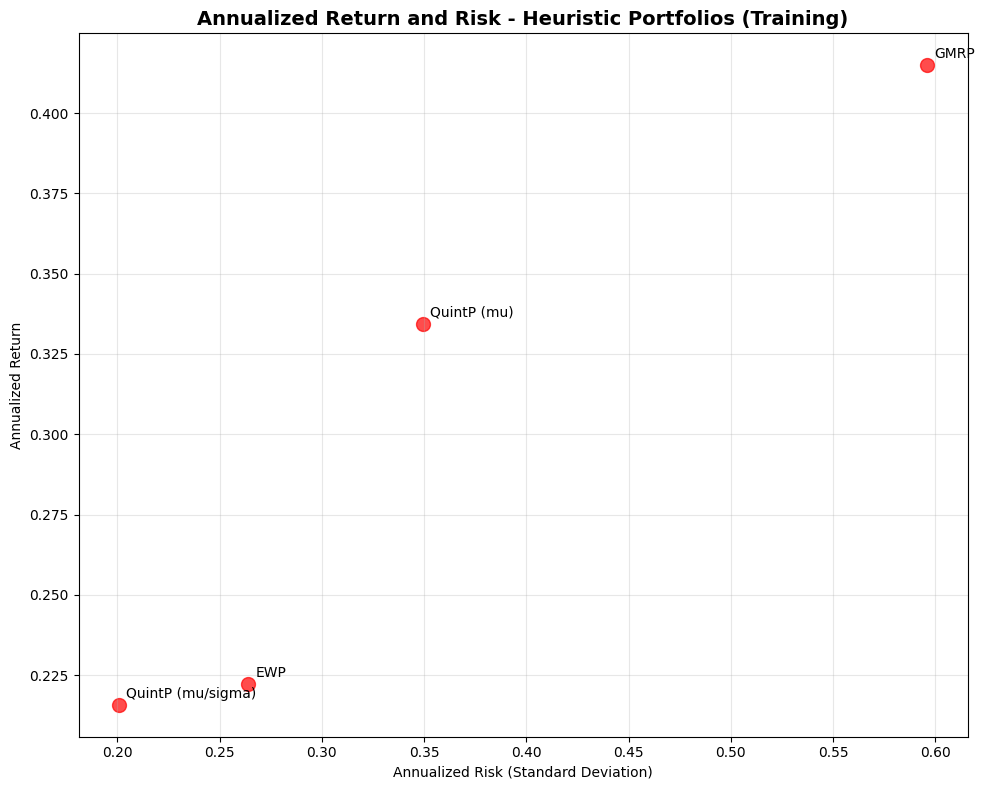

In [44]:
# Risk-Return scatter plot for heuristic portfolios (training data)
annual_ret_heur = ret_heuristic_trn.mean() * 252
annual_vol_heur = ret_heuristic_trn.std() * np.sqrt(252)

plt.figure(figsize=(10, 8))
plt.scatter(annual_vol_heur, annual_ret_heur, s=100, c='red', alpha=0.7)

# Add labels for each point
for i, portfolio in enumerate(ret_heuristic_trn.columns):
    plt.annotate(portfolio, (annual_vol_heur.iloc[i], annual_ret_heur.iloc[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.title('Annualized Return and Risk - Heuristic Portfolios (Training)', fontsize=14, fontweight='bold')
plt.xlabel('Annualized Risk (Standard Deviation)')
plt.ylabel('Annualized Return')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary and Conclusions

This notebook demonstrates the implementation of several heuristic portfolio strategies:

1. **Buy & Hold (B&H)**: Individual stock strategies
2. **Equal-Weighted Portfolio (EWP)**: Simple diversification
3. **Quintile Portfolios**: Based on different ranking criteria
4. **Global Maximum Return Portfolio (GMRP)**: Single best-performing stock

Key observations:
- In-sample performance often doesn't translate to out-of-sample performance
- Diversification (EWP) can provide more stable returns
- Single-stock strategies (B&H, GMRP) are more volatile
- The choice of ranking criterion for quintile portfolios affects performance